## Notebook 3: Final Analysis and Visualisations

In [ ]:

import pandas as pd
import numpy as np
import networkx as nx
import numpy as np
import igraph as ig
import leidenalg
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import praw
commentFrame = pd.read_pickle("comments.pkl")
with open("Giant_comp.pkl", "rb") as f:
    graph = pickle.load(f)
reddit = praw.Reddit("project")

subreddit = reddit.submission(id = commentFrame['original post'].iloc[0]).subreddit.display_name


419642


### Calculating Assortivity and Modularity

In [53]:

deg_assort = nx.degree_assortativity_coefficient(graph)
deg_assort = (deg_assort+1)/2
print('Degree assortivity:', deg_assort)

assort = nx.attribute_assortativity_coefficient(graph, "sentiment")
assort = (assort+1)/2
print(f"sentiment assortivity: {assort}")

nodeList = list(graph.nodes())
edges = [(nodeList.index(u), nodeList.index(v)) for u, v in graph.edges()]
g = ig.Graph(n = len(nodeList), edges = edges, directed = False)

if nx.get_edge_attributes(graph, "weight"):
    g.es["weight"] = [graph[u][v].get("weight", 1.0) for u, v in graph.edges()]
if nx.get_node_attributes(graph, "sentiment"):
    g.vs["sentiment"] = [graph.nodes[n].get("sentiment", 0) for n in graph.nodes()]

partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, seed = 7)
print("Modularity:", partition.quality())

Degree assortivity: 0.6690290489826516
sentiment assortivity: 0.5047165455042206
Modularity: 0.6897376662667882


### Calculating Sentiment Skew and Transitivity

In [54]:




weights = commentFrame['upvotes'].clip(lower=0).fillna(0)
pos_weight = weights[commentFrame['sentimentLabel'] == 1].sum()
neg_weight = weights[commentFrame['sentimentLabel'] == -1].sum()
total_weight = pos_weight + neg_weight
if total_weight == 0:
    sentiment_skew = 0.5
else:
    pos_skew = pos_weight/total_weight
    neg_skew = neg_weight/total_weight
    sentiment_skew = max(pos_skew, neg_skew)
print(f'sentiment skew: {sentiment_skew}')

avg_clust = g.transitivity_undirected() 
print(f'Transitivity: {avg_clust}')


sentiment skew: 0.7829360726039692
Transitivity: 0.8130469006891531


### Spider Graph of ECI metrics
Metric Definitions (higher = more 'echo chamber' like)

Degree Assortivity: tests if high degree (very active) users interact more with other high degree users. 

Sentiment Skew:  Shows whether the overall converation is heavily tilted towards positive or negative sentiment

Sentiment Assortivity: tests if users tend to interact more with others who share the same sentiment. 

Modularity: quantifies how strongly the graph splits into tight sub communities. 

Transitivity: fraction of user triplets that are all connected, showing how tightly users interact with each other.

Text(0.2, 0.05, 'Echo Chamber index: 0.69')

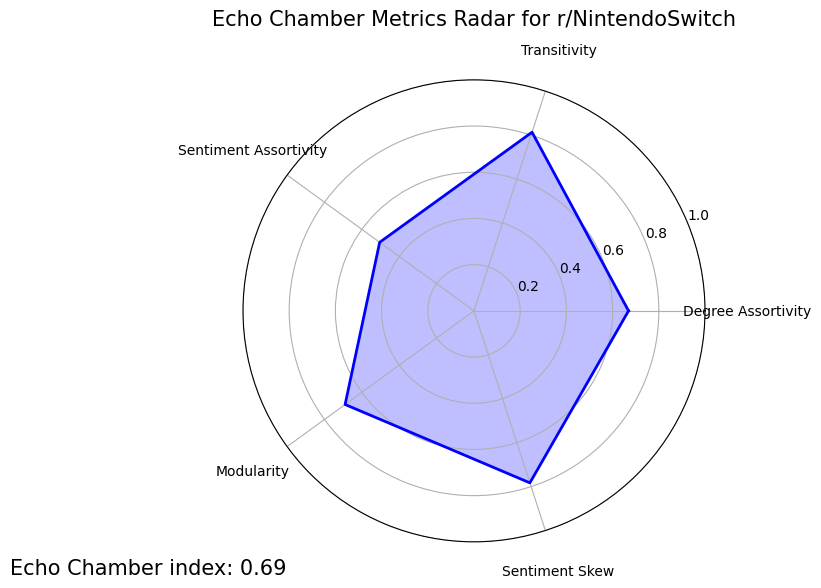

In [55]:

labels = ['Degree Assortivity', 'Transitivity', 'Sentiment Assortivity', 'Modularity', 'Sentiment Skew']
num_vars = len(labels)
values = [deg_assort, avg_clust, assort, partition.quality(), sentiment_skew]
ECI = np.mean(values)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
values += values[:1]
labels += labels[:1]


fig, ax = plt.subplots(figsize = (6,6), subplot_kw= dict(polar = True))

ax.plot(angles, values, color='b', linewidth=2, linestyle='solid')
ax.fill(angles, values, color='b', alpha = 0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels[:-1])
ax.set_ylim(0,1)

for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')
    label.set_y(label.get_position()[1] - 0.1)


ax.set_title(f'Echo Chamber Metrics Radar for r/{subreddit}', size = 15, y = 1.1)

fig.text(
    0.2, 0.05,               
    f"Echo Chamber index: {ECI:.2f}",
    ha="right", va="bottom",
    fontsize=15, color="black"
)

### Graph of Sub-Communities within the subreddit
This graph shows if the subreddit splits into smaller sub communities, and if those communities are isolated or highly connected to the rest of the subreddit.

Lots of isolated nodes = subreddit splits into smaller echo chambers.

Most nodes connected (with large edges) = subreddit is one large connected echo chamber.



Legend:

Green node -> positive sub-community sentiment. 

Yellow node -> neutral sub community sentiment. 

Red node -> negative sub community sentiment. 

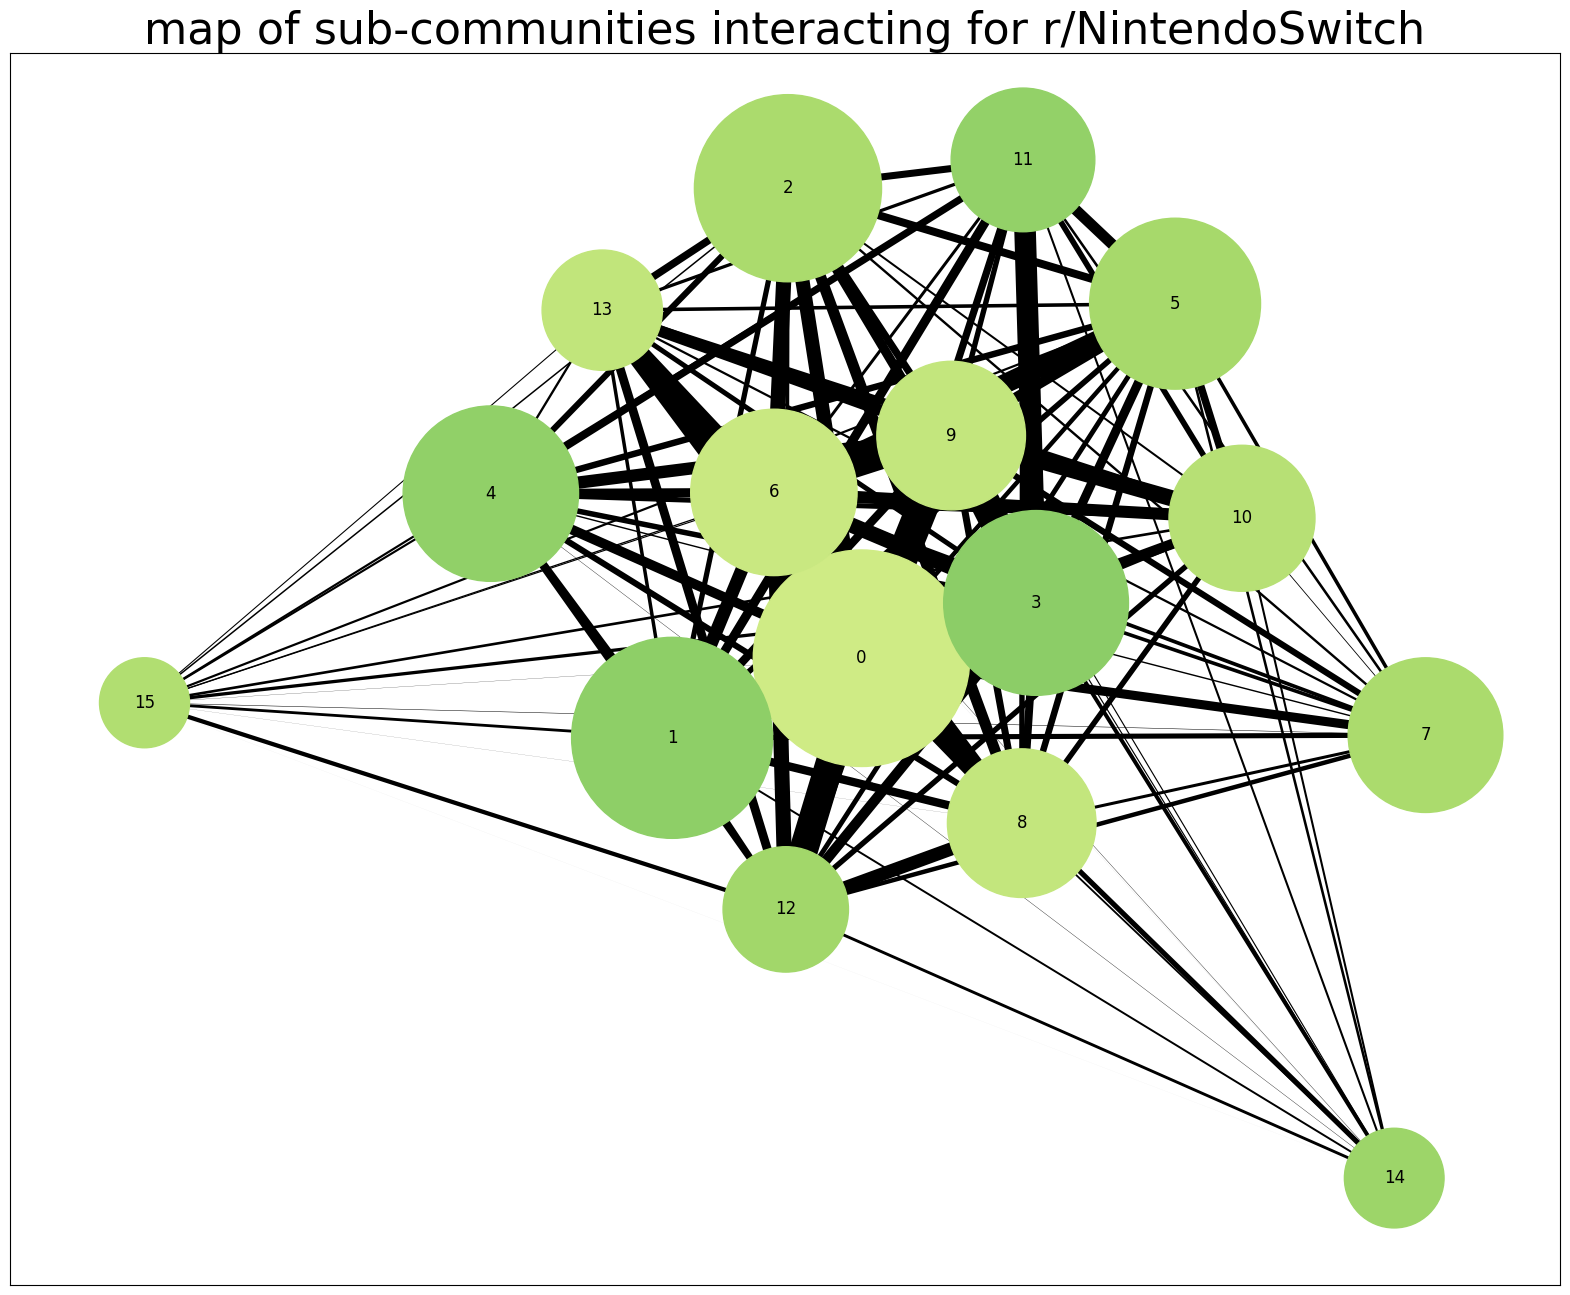

In [60]:
community_graph = nx.Graph()

node_to_comm = {}
for index, nodes in enumerate(partition):
    for node in nodes:
        node_to_comm[node] = index
    
    sentiment = np.mean([g.vs[v]['sentiment'] for v in nodes])
    community_graph.add_node(index, size = len(nodes) * 50, sentiment = sentiment)

for e in g.es:
    u,v = e.tuple
    u_community = node_to_comm[u] 
    v_community = node_to_comm[v]

    if u_community != v_community:
        edge = tuple(sorted((u_community, v_community)))  
        
        
        if community_graph.has_edge(*edge):
            community_graph[edge[0]][edge[1]]['weight'] += 1
        else:
            community_graph.add_edge(edge[0], edge[1], weight=1)


node_sizes = [community_graph.nodes[n]['size'] + 50 for n in community_graph.nodes]
width = [data['weight'] * 0.01 for u,v,data in community_graph.edges(data = True)]
norm = plt.Normalize(vmin= -1, vmax = 1)
color_map = plt.cm.RdYlGn
node_colors = [color_map(norm(community_graph.nodes[v]['sentiment'])) for v in community_graph.nodes()]


pos = nx.spring_layout(community_graph, seed = 43, k=5)

plt.figure(figsize=(20,16))
plt.title(f'map of sub-communities interacting for r/{subreddit}', fontsize = 32)
nx.draw_networkx(community_graph,
                  pos=pos,
                  node_size = node_sizes,
                  width = width,
                  node_color = node_colors
                  )



### Degree Histogram
degree of a user = how many other users have interacted on the same posts as this user

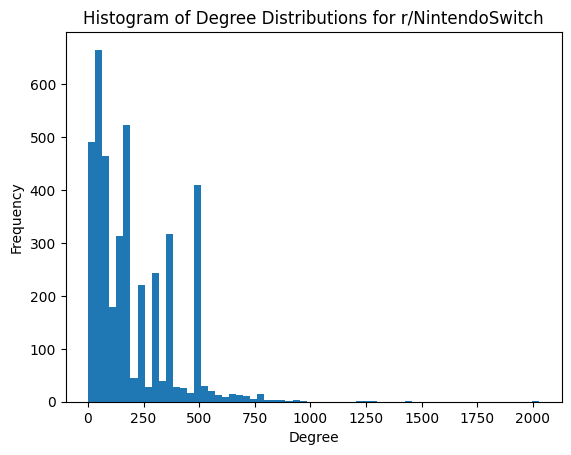

In [61]:
degrees = [graph.degree(n) for n in graph.nodes]
num = int(np.sqrt(graph.number_of_nodes()))
plt.ylabel("Frequency")
plt.xlabel("Degree")

plt.title(f"Histogram of Degree Distributions for r/{subreddit}")
plt.hist(degrees, bins = num)

plt.show()

### Average upvotes per sentiment
Shows what type of comments are rewarded the most in the community

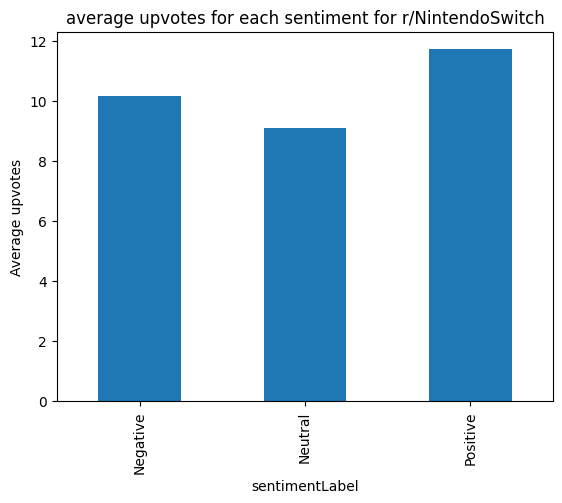

In [62]:

avg_upvotes = commentFrame.groupby('sentimentLabel')['upvotes'].mean()
label_map = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
avg_upvotes.index = avg_upvotes.index.map(label_map)
ax = avg_upvotes.plot(kind='bar')

plt.title(f'average upvotes for each sentiment for r/{subreddit}')
plt.ylabel('Average upvotes')
plt.show()

### Average sentiment per sub community
The sentiment ranes from -1 (negative) to +1 (positive), though this chart is zoomed into the observed range for readability

<BarContainer object of 16 artists>

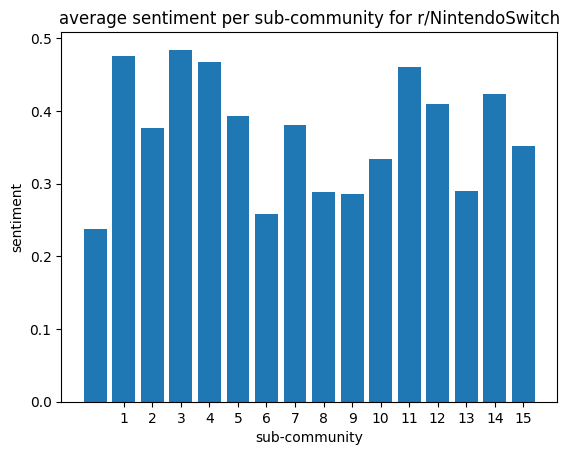

In [63]:
comms = [comms for comms in partition if len(comms) >> 4]
x = [index for index, _ in enumerate(comms)]
y = [np.mean([g.vs[v]['sentiment'] for v in comm]) for comm in comms]
plt.ylabel('sentiment')
plt.xlabel('sub-community')
plt.xticks(range(1, len(partition)))
plt.title(f'average sentiment per sub-community for r/{subreddit}')
plt.bar(x, y)